In [1]:
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy import signal

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# data_dir = "/Users/trevoryu/Code/syde_599/data/norm_fog_data/"
data_dir = 'drive/MyDrive/norm_fog_data/'

data_files = glob.glob(data_dir + "*.csv")
len(data_files)

56

# Load the data

In [4]:
WINDOW_SIZE = 650
WINDOW_STEP = 200

train_X = []
train_Y = []
test_X = []
test_Y = []

for file in data_files:
    print(file)
    path_parts = file.split('/')
    patient_num = path_parts[-1].split('_')[0]
    
    data = np.loadtxt(file, delimiter=",", skiprows=1)
    # Timestamp is in col 0, labels are in col 1
    # Data is in cols 2 to end
    y = data[:, 1]
    x = data[:, 2:]
    y[y<0] = 0
    y[y>0] = 1
    print(y.sum())
    # Remove both waist and right shank columns since test data is missing there
    #channels_to_remove = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]  # These are channel inds AFTER removing timestamp and labels
    #x = np.delete(x, channels_to_remove, axis=1)


    # Split into non-overlapping windows
    # Don't use the last bit of data that doesn't fill a whole window
    n_windows = y.size // WINDOW_SIZE
    end = WINDOW_SIZE * n_windows
    x = x[:end, :]  # (n_samples, d)
    y = y[:end]

    # Reshape into (n_windows, window_size, d)
    #x = x.reshape(n_windows, WINDOW_SIZE, -1)
    #y = y.reshape(n_windows, WINDOW_SIZE)
    # Split into overlapping windows
    x = np.lib.stride_tricks.sliding_window_view(x, WINDOW_SIZE, axis=0)[::WINDOW_STEP]
    y = np.lib.stride_tricks.sliding_window_view(y, WINDOW_SIZE, axis=0)[::WINDOW_STEP]

    x = x.transpose(0,2,1)
    
    
    if patient_num in ('001', '009', '010'):
        test_X.append(x)
        test_Y.append(y)
    else:
        train_X.append(x)
        train_Y.append(y)

drive/MyDrive/norm_fog_data/001_task_1.csv
65500.0
drive/MyDrive/norm_fog_data/002_task_2.csv
0.0
drive/MyDrive/norm_fog_data/003_task_1.csv
588000.0
drive/MyDrive/norm_fog_data/001_task_2.csv
64500.0
drive/MyDrive/norm_fog_data/002_task_3.csv
0.0
drive/MyDrive/norm_fog_data/002_task_1.csv
0.0
drive/MyDrive/norm_fog_data/001_task_3.csv
0.0
drive/MyDrive/norm_fog_data/002_task_4.csv
1500.0
drive/MyDrive/norm_fog_data/001_task_4.csv
0.0
drive/MyDrive/norm_fog_data/003_task_4.csv
26500.0
drive/MyDrive/norm_fog_data/004_task_1.csv
0.0
drive/MyDrive/norm_fog_data/003_task_2.csv
237000.0
drive/MyDrive/norm_fog_data/003_task_3.csv
26500.0
drive/MyDrive/norm_fog_data/004_task_2.csv
60000.0
drive/MyDrive/norm_fog_data/006_task_4.csv
16500.0
drive/MyDrive/norm_fog_data/005_task_4.csv
0.0
drive/MyDrive/norm_fog_data/004_task_5.csv
4500.0
drive/MyDrive/norm_fog_data/004_task_3.csv
0.0
drive/MyDrive/norm_fog_data/006_task_1.csv
67000.0
drive/MyDrive/norm_fog_data/005_task_2.csv
0.0
drive/MyDrive/no

In [5]:
train_X = np.concatenate(train_X, axis=0)
train_Y = np.concatenate(train_Y, axis=0)

test_X = np.concatenate(test_X, axis=0)
test_Y = np.concatenate(test_Y, axis=0)

# Example of augmentation applied

In [ ]:
train_X.shape

(8192, 650, 18)

In [ ]:
train_X.shape

(26506, 650, 30)

In [ ]:
y = train_X[0, :, 0]

In [ ]:
y_stretch = signal.resample(y, int(len(y) * 1.1))
y_squeeze = signal.resample(y, int(len(y) * 0.9))
y_shrink = y * 0.8
y_scaled = y * 1.2

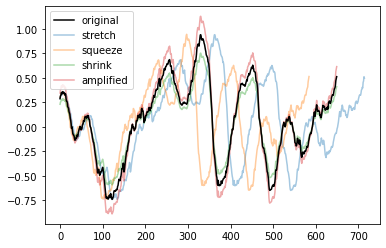

In [ ]:
plt.plot(y, label="original", zorder=4, c='k')
plt.plot(y_stretch, label="stretch", alpha=0.4)
plt.plot(y_squeeze, label="squeeze", alpha=0.4)
plt.plot(y_shrink, label="shrink", alpha=0.4)
plt.plot(y_scaled, label="amplified", alpha=0.4)
plt.legend()
plt.show()

In [ ]:
# Build dataset, dataloader, collate function

In [6]:
class FoGDataset(torch.utils.data.Dataset):
    def __init__(self, data_x, data_y):
        """
        Parameters:
        -----------
        data_x: np.ndarray of shape (num_samples, window_size, num_features) which contains data features for FoG
        data_y: np.ndarray of shape (num_samples, window_size) which contains binary labels for FoG
        """
        super().__init__()
        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):
        return self.data_x.shape[0]

    def __getitem__(self, index):
        """Returns tuple of (data, label) at index"""
        inputs = self.data_x[index, :, :]
        labels = self.data_y[index, :]
        return inputs, labels


class FoGDataAugment:
    """
    Collate function to apply random time stretch/squeeze and signal shrink/scale
    Apply stretch/squeeze to the time dimension by resampling and truncating to out_samples
        The lower bound of stretch must satisfy (lb * len(input)) > out_samples
    """
    def __init__(self, out_samples=512, p=0.5, stretch=(0.8, 1.2), scale=(0.8, 1.2)):
        """
        Parameters:
        -----------
        p: float between [0, 1], probability of applying each the stretch and scale transform independently
        strech: tuple of float, upper and lower bound on time stretch factor
        scale: tuple of float, upper and lower bound on signal scale factor
        """
        self.p = p
        self.stretch = stretch
        self.scale = scale
        self.out_samples = out_samples
    
    def _reduce_labels(self, y):
        """If there is a 1 in the label, then return 1"""
        return np.any(y == 1, axis=-1).astype(int)

    def _random_crop(self, inputs, labels):
        """Apply a random crop of the signal of length self.out_samples to both inputs and labels"""
        n, d = inputs.shape
        max_offset = n - self.out_samples
        offset = np.random.choice(max_offset)
        inds = slice(offset, offset + self.out_samples)
        return inputs[inds, :], labels[inds]

    def __call__(self, data):
        """
        Parameters:
        -----------
        data: list of tuple of (inputs, labels) of length batch_size
            inputs: np.ndarray, dimensions (n_samples, n_channels), signal data
            labels: np.ndarray, dimensions (n_samples,), binary label vector for the signal data

        Returns:
        --------
        (inputs, labels): augmented signal data, reduced labels
        """
        x = []
        y = []
        for (inputs, labels) in data:
            n, d = inputs.shape
            assert (self.stretch[0] * n) >= self.out_samples, f"input size {n} must be greater than {int(self.out_samples / self.stretch[0])} to apply augmentation"

            # Randomly apply time stretch
            if np.random.binomial(1, self.p) != 0:
                lb, ub = self.stretch
                stretch = np.random.uniform(lb, ub)
                inputs = signal.resample(inputs, int(n * stretch), axis=0)  # Resample the time (n_samples) axis
            if np.random.binomial(1, self.p) != 0:
                lb, ub = self.scale
                scale = np.random.uniform(lb, ub)
                inputs = scale * inputs  # Scale all channels equally
            
            # Apply random crop to self.out_size on both inputs and labels
            inputs, labels = self._random_crop(inputs, labels)

            labels = self._reduce_labels(labels)
            x.append(inputs)
            y.append(labels)
        collated_inputs = torch.tensor(x, dtype=torch.float32)
        collated_labels = torch.tensor(y, dtype=torch.float32)
        return collated_inputs, collated_labels

In [7]:
train_dataset = FoGDataset(train_X, train_Y)
test_dataset = FoGDataset(test_X, test_Y)

augment_fn = FoGDataAugment(out_samples=512)
test_augment = FoGDataAugment(out_samples=512, p=0)

BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=augment_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=test_augment)

In [8]:
del train_X, train_Y, test_X, test_Y, train_dataset, test_dataset

# Define model

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, n_layers=3, in_features=30, d_model=128, n_heads=8, dropout=0.1):
        super().__init__()
        self.d_model = d_model

        self.input_transform = nn.Linear(in_features, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dropout=dropout,
            dim_feedforward=4*d_model,
            activation="gelu",
            batch_first=True,
            norm_first=True)

        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers)
        self.layer_norm = nn.LayerNorm(d_model)

        # We'll just make a prediction on the features of the first and last sequence point
        self.classifier = nn.Linear(d_model * 2, 1)
    
    def forward(self, x):
        x = self.input_transform(x)
        x = self.encoder(x)
        x = self.layer_norm(x)

        x = x[:, [0, -1], :].reshape(-1, 2 * self.d_model)
        x = self.classifier(x)
        return x

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, fc_dim, bidirectional):
        super(LSTMModel, self).__init__()

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=bidirection
        )

        # Fully connected layer
        self.fc = nn.Linear(fc_dim, output_dim)

    def forward(self, x):

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x)
        
        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out.flatten(start_dim=-2))

        return out

In [ ]:
class CNNLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, fc_dim, bidirection):
        super(CNNLSTMModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=30, out_channels=64, kernel_size=4)
        self.mp = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=64,out_channels=32,kernel_size=4)


          # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=bidirection
        )

        # Fully connected layer
        self.fc1 = nn.Linear(fc_dim, 128)
        self.fc2 = nn.Linear(128, 1)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
       
        out = self.conv1(x.transpose(1,2))
        out = self.mp(out)
        #out = self.conv2(out)
        #out = self.mp(out)
        
        #out = self.conv2(out)
        #out = self.mp(out)
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(out.transpose(1,2))
        
        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc1(out.flatten(start_dim=-2))
        out = self.fc2(out)
        #out = self.fc3(out)

        return out

In [34]:
class CNNLSTM(nn.Module):
    def __init__(self, input_features=30, dropout_prob=0.5, padding = 'valid', mp=2, pool='max', input_dim=1, hidden_dim=1, layer_dim=1, output_dim=1, fc_dim=1, bidirection=True):
        super(CNNLSTM, self).__init__()

        self.conv1 = nn.Conv1d(input_features, 32, kernel_size=32, stride=2)
        self.mp = nn.MaxPool1d(mp, stride=mp)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=16)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=8)

        self.conv4 = nn.Conv1d(128, 1, kernel_size=4)
        self.dropout = nn.Dropout(dropout_prob)

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=bidirection
        )

        # Fully connected layer
        self.fc = nn.Linear(fc_dim, output_dim)


    def forward(self, x):
        x = self.conv1(x.transpose(1,2))
        # print(x.shape)
        x = F.relu(x)
        x = self.mp(x)
        #print(x.shape)
        x = self.conv2(x)
        # print(x.shape)
        x = F.relu(x)
        x = self.mp(x)

        x = self.conv3(x)
        # print(x.shape)
        x = F.relu(x)
        
        x = self.conv4(x)
        # print(x.shape)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        
        x, _ = self.lstm(x)
        
        x = self.fc(x)
        return x

# Training

In [10]:
def train(model, dataloader, optimizer, criterion, epoch, logging_steps=20, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.train()
    total_loss = 0
    correct = 0
    loss_history = []
    for i, (inputs, targets) in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        outputs = outputs.flatten()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss
        loss_history.append(loss.item())
        preds = torch.round(torch.sigmoid(outputs))
        correct += torch.sum(preds == targets).detach().cpu()

        if i % logging_steps == 0:
            print(f'Epoch: {epoch} ({i}/{len(dataloader)}) Training loss: {loss}')

    accuracy = correct / (dataloader.batch_size * len(dataloader))
    print(f'Epoch {epoch} done. Training loss: {total_loss/len(dataloader)} Training accuracy: {accuracy}')
    return accuracy, total_loss/len(dataloader), loss_history

In [11]:
def evaluate(model, dataloader, criterion, epoch, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (inputs, targets) in tqdm(enumerate(dataloader)):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            outputs = outputs.flatten()
            loss = criterion(outputs, targets)

            total_loss += loss
            preds = torch.round(torch.sigmoid(outputs))
            
            correct += torch.sum(preds == targets).detach().cpu()

        accuracy = correct / (dataloader.batch_size * len(dataloader))
        print(f'Epoch {epoch} done. Eval loss: {total_loss/len(dataloader)} Eval accuracy: {accuracy}')
    return accuracy, total_loss/len(dataloader)

In [49]:
input_dim = 42
hidden_dim = 4 
layer_dim = 1
output_dim = 1 
dropout_prob = 0.5
fc_dim = 8
bidirection = True
model = CNNLSTM(input_features=30, dropout_prob=0.5, padding = 'valid', mp=2, pool='max', input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=output_dim, fc_dim=fc_dim, bidirection=bidirection)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
criterion = nn.BCEWithLogitsLoss()
EPOCHS = 10

loss_history = []
train_acc_history = []
eval_acc_history = []
eval_loss_history = []
for epoch in range(EPOCHS):
    train_acc, train_loss, history = train(model, train_loader, optimizer, criterion, epoch)
    eval_acc, eval_loss = evaluate(model, test_loader, criterion, epoch)
    
    loss_history.extend(history)
    eval_loss_history.append(eval_loss)
    train_acc_history.append(train_acc)
    eval_acc_history.append(eval_acc)
    

2it [00:00,  8.90it/s]

Epoch: 0 (0/360) Training loss: 0.696784496307373


22it [00:02,  8.37it/s]

Epoch: 0 (20/360) Training loss: 0.6727320551872253


42it [00:04,  8.55it/s]

Epoch: 0 (40/360) Training loss: 0.6600127220153809


62it [00:07,  8.82it/s]

Epoch: 0 (60/360) Training loss: 0.641897976398468


82it [00:09,  8.87it/s]

Epoch: 0 (80/360) Training loss: 0.6295894384384155


102it [00:11,  8.70it/s]

Epoch: 0 (100/360) Training loss: 0.6120108962059021


122it [00:14,  8.38it/s]

Epoch: 0 (120/360) Training loss: 0.6034926772117615


142it [00:16,  8.76it/s]

Epoch: 0 (140/360) Training loss: 0.5832045674324036


162it [00:18,  8.85it/s]

Epoch: 0 (160/360) Training loss: 0.6067796945571899


182it [00:21,  8.51it/s]

Epoch: 0 (180/360) Training loss: 0.5410553216934204


202it [00:23,  8.68it/s]

Epoch: 0 (200/360) Training loss: 0.47453436255455017


222it [00:25,  8.66it/s]

Epoch: 0 (220/360) Training loss: 0.5025134682655334


242it [00:27,  8.61it/s]

Epoch: 0 (240/360) Training loss: 0.5869114398956299


262it [00:30,  8.95it/s]

Epoch: 0 (260/360) Training loss: 0.520044207572937


282it [00:32,  7.94it/s]

Epoch: 0 (280/360) Training loss: 0.48654136061668396


302it [00:34,  8.77it/s]

Epoch: 0 (300/360) Training loss: 0.4138643741607666


322it [00:37,  8.24it/s]

Epoch: 0 (320/360) Training loss: 0.5069635510444641


342it [00:39,  8.58it/s]

Epoch: 0 (340/360) Training loss: 0.3908015787601471


360it [00:41,  8.63it/s]


Epoch 0 done. Training loss: 0.5560433268547058 Training accuracy: 0.7560763955116272


123it [00:10, 11.90it/s]


Epoch 0 done. Eval loss: 0.6067556738853455 Eval accuracy: 0.6961382031440735


1it [00:00,  8.72it/s]

Epoch: 1 (0/360) Training loss: 0.48987624049186707


22it [00:02,  8.75it/s]

Epoch: 1 (20/360) Training loss: 0.4255276024341583


42it [00:04,  8.85it/s]

Epoch: 1 (40/360) Training loss: 0.4110257029533386


62it [00:07,  8.47it/s]

Epoch: 1 (60/360) Training loss: 0.4808591306209564


82it [00:09,  8.64it/s]

Epoch: 1 (80/360) Training loss: 0.4661329388618469


102it [00:11,  8.16it/s]

Epoch: 1 (100/360) Training loss: 0.3811855912208557


122it [00:14,  8.84it/s]

Epoch: 1 (120/360) Training loss: 0.44503533840179443


142it [00:16,  8.83it/s]

Epoch: 1 (140/360) Training loss: 0.4166327118873596


162it [00:18,  8.49it/s]

Epoch: 1 (160/360) Training loss: 0.48602229356765747


182it [00:21,  8.77it/s]

Epoch: 1 (180/360) Training loss: 0.3398764133453369


202it [00:23,  8.82it/s]

Epoch: 1 (200/360) Training loss: 0.5036909580230713


222it [00:25,  8.65it/s]

Epoch: 1 (220/360) Training loss: 0.3579641282558441


242it [00:27,  8.58it/s]

Epoch: 1 (240/360) Training loss: 0.44687747955322266


262it [00:30,  8.86it/s]

Epoch: 1 (260/360) Training loss: 0.43187275528907776


282it [00:32,  8.66it/s]

Epoch: 1 (280/360) Training loss: 0.40486782789230347


302it [00:34,  8.85it/s]

Epoch: 1 (300/360) Training loss: 0.4877994954586029


322it [00:37,  8.76it/s]

Epoch: 1 (320/360) Training loss: 0.41077756881713867


342it [00:39,  8.50it/s]

Epoch: 1 (340/360) Training loss: 0.3670068085193634


360it [00:41,  8.67it/s]


Epoch 1 done. Training loss: 0.4125900864601135 Training accuracy: 0.8415798544883728


123it [00:11, 10.39it/s]


Epoch 1 done. Eval loss: 0.46508899331092834 Eval accuracy: 0.7905233502388


1it [00:00,  7.83it/s]

Epoch: 2 (0/360) Training loss: 0.5672650933265686


22it [00:02,  8.57it/s]

Epoch: 2 (20/360) Training loss: 0.41301411390304565


42it [00:04,  8.83it/s]

Epoch: 2 (40/360) Training loss: 0.4681888818740845


62it [00:07,  8.54it/s]

Epoch: 2 (60/360) Training loss: 0.40340757369995117


82it [00:09,  8.72it/s]

Epoch: 2 (80/360) Training loss: 0.29833292961120605


102it [00:11,  8.54it/s]

Epoch: 2 (100/360) Training loss: 0.4531170129776001


122it [00:14,  8.48it/s]

Epoch: 2 (120/360) Training loss: 0.33358144760131836


142it [00:16,  8.48it/s]

Epoch: 2 (140/360) Training loss: 0.3366406559944153


162it [00:18,  8.74it/s]

Epoch: 2 (160/360) Training loss: 0.4842347800731659


182it [00:21,  8.62it/s]

Epoch: 2 (180/360) Training loss: 0.26435399055480957


202it [00:23,  8.88it/s]

Epoch: 2 (200/360) Training loss: 0.5080999135971069


222it [00:25,  8.87it/s]

Epoch: 2 (220/360) Training loss: 0.4275761842727661


242it [00:28,  8.33it/s]

Epoch: 2 (240/360) Training loss: 0.3067997694015503


262it [00:30,  8.68it/s]

Epoch: 2 (260/360) Training loss: 0.49154752492904663


282it [00:32,  8.33it/s]

Epoch: 2 (280/360) Training loss: 0.3656139671802521


302it [00:35,  8.84it/s]

Epoch: 2 (300/360) Training loss: 0.27238214015960693


322it [00:37,  8.74it/s]

Epoch: 2 (320/360) Training loss: 0.23774880170822144


342it [00:39,  8.66it/s]

Epoch: 2 (340/360) Training loss: 0.27089929580688477


360it [00:41,  8.66it/s]


Epoch 2 done. Training loss: 0.36092856526374817 Training accuracy: 0.864062488079071


123it [00:10, 11.74it/s]


Epoch 2 done. Eval loss: 0.44655126333236694 Eval accuracy: 0.808307945728302


1it [00:00,  8.60it/s]

Epoch: 3 (0/360) Training loss: 0.3050260543823242


22it [00:02,  8.65it/s]

Epoch: 3 (20/360) Training loss: 0.35995033383369446


42it [00:04,  8.26it/s]

Epoch: 3 (40/360) Training loss: 0.40667980909347534


62it [00:07,  8.77it/s]

Epoch: 3 (60/360) Training loss: 0.2471226155757904


82it [00:09,  8.76it/s]

Epoch: 3 (80/360) Training loss: 0.30657958984375


102it [00:11,  8.84it/s]

Epoch: 3 (100/360) Training loss: 0.42389366030693054


122it [00:14,  8.63it/s]

Epoch: 3 (120/360) Training loss: 0.3559494912624359


142it [00:16,  8.38it/s]

Epoch: 3 (140/360) Training loss: 0.3332349359989166


162it [00:18,  8.60it/s]

Epoch: 3 (160/360) Training loss: 0.37367403507232666


182it [00:20,  8.67it/s]

Epoch: 3 (180/360) Training loss: 0.31133049726486206


202it [00:23,  8.77it/s]

Epoch: 3 (200/360) Training loss: 0.3988820016384125


222it [00:25,  8.54it/s]

Epoch: 3 (220/360) Training loss: 0.24730266630649567


242it [00:27,  8.62it/s]

Epoch: 3 (240/360) Training loss: 0.417402058839798


262it [00:30,  7.92it/s]

Epoch: 3 (260/360) Training loss: 0.2846974730491638


282it [00:32,  8.68it/s]

Epoch: 3 (280/360) Training loss: 0.36545777320861816


302it [00:35,  8.87it/s]

Epoch: 3 (300/360) Training loss: 0.22141814231872559


322it [00:37,  8.89it/s]

Epoch: 3 (320/360) Training loss: 0.3054169714450836


342it [00:39,  8.82it/s]

Epoch: 3 (340/360) Training loss: 0.2791746258735657


360it [00:41,  8.65it/s]


Epoch 3 done. Training loss: 0.32423272728919983 Training accuracy: 0.8793402910232544


123it [00:10, 11.82it/s]


Epoch 3 done. Eval loss: 0.5679231286048889 Eval accuracy: 0.7709603905677795


1it [00:00,  9.01it/s]

Epoch: 4 (0/360) Training loss: 0.44357264041900635


22it [00:02,  8.77it/s]

Epoch: 4 (20/360) Training loss: 0.27001067996025085


42it [00:04,  9.07it/s]

Epoch: 4 (40/360) Training loss: 0.3117826282978058


62it [00:07,  8.52it/s]

Epoch: 4 (60/360) Training loss: 0.18710921704769135


82it [00:09,  8.70it/s]

Epoch: 4 (80/360) Training loss: 0.3800472617149353


102it [00:11,  8.38it/s]

Epoch: 4 (100/360) Training loss: 0.31689026951789856


122it [00:14,  8.84it/s]

Epoch: 4 (120/360) Training loss: 0.22465229034423828


142it [00:16,  8.56it/s]

Epoch: 4 (140/360) Training loss: 0.22783344984054565


162it [00:18,  8.53it/s]

Epoch: 4 (160/360) Training loss: 0.24558085203170776


182it [00:21,  8.80it/s]

Epoch: 4 (180/360) Training loss: 0.2479676753282547


202it [00:23,  8.76it/s]

Epoch: 4 (200/360) Training loss: 0.28124451637268066


222it [00:25,  8.55it/s]

Epoch: 4 (220/360) Training loss: 0.3536628186702728


242it [00:27,  8.82it/s]

Epoch: 4 (240/360) Training loss: 0.308724045753479


262it [00:30,  8.65it/s]

Epoch: 4 (260/360) Training loss: 0.2935894727706909


282it [00:32,  8.75it/s]

Epoch: 4 (280/360) Training loss: 0.3243691325187683


302it [00:34,  8.46it/s]

Epoch: 4 (300/360) Training loss: 0.33838340640068054


322it [00:37,  8.53it/s]

Epoch: 4 (320/360) Training loss: 0.33289122581481934


342it [00:39,  8.07it/s]

Epoch: 4 (340/360) Training loss: 0.4072510600090027


360it [00:41,  8.64it/s]


Epoch 4 done. Training loss: 0.3007482886314392 Training accuracy: 0.8865017294883728


123it [00:10, 11.76it/s]


Epoch 4 done. Eval loss: 0.57558673620224 Eval accuracy: 0.7610518336296082


1it [00:00,  8.57it/s]

Epoch: 5 (0/360) Training loss: 0.24734023213386536


22it [00:02,  8.71it/s]

Epoch: 5 (20/360) Training loss: 0.21827715635299683


42it [00:04,  8.48it/s]

Epoch: 5 (40/360) Training loss: 0.22257259488105774


62it [00:07,  8.89it/s]

Epoch: 5 (60/360) Training loss: 0.46782803535461426


82it [00:09,  8.90it/s]

Epoch: 5 (80/360) Training loss: 0.33217209577560425


102it [00:11,  8.85it/s]

Epoch: 5 (100/360) Training loss: 0.3836338520050049


122it [00:14,  8.76it/s]

Epoch: 5 (120/360) Training loss: 0.2693687379360199


142it [00:16,  7.72it/s]

Epoch: 5 (140/360) Training loss: 0.29599979519844055


162it [00:18,  8.73it/s]

Epoch: 5 (160/360) Training loss: 0.2823638319969177


182it [00:21,  8.52it/s]

Epoch: 5 (180/360) Training loss: 0.3672735095024109


202it [00:23,  8.77it/s]

Epoch: 5 (200/360) Training loss: 0.3646986484527588


222it [00:25,  8.73it/s]

Epoch: 5 (220/360) Training loss: 0.3531203269958496


242it [00:28,  8.78it/s]

Epoch: 5 (240/360) Training loss: 0.25100237131118774


262it [00:30,  8.61it/s]

Epoch: 5 (260/360) Training loss: 0.2732751965522766


282it [00:32,  8.54it/s]

Epoch: 5 (280/360) Training loss: 0.17946641147136688


302it [00:34,  8.77it/s]

Epoch: 5 (300/360) Training loss: 0.3195512890815735


322it [00:37,  8.78it/s]

Epoch: 5 (320/360) Training loss: 0.39270448684692383


342it [00:39,  8.45it/s]

Epoch: 5 (340/360) Training loss: 0.19961296021938324


360it [00:41,  8.66it/s]


Epoch 5 done. Training loss: 0.2777443528175354 Training accuracy: 0.8976128697395325


123it [00:10, 11.67it/s]


Epoch 5 done. Eval loss: 0.5437843799591064 Eval accuracy: 0.7743902206420898


1it [00:00,  8.76it/s]

Epoch: 6 (0/360) Training loss: 0.3080981969833374


22it [00:02,  8.71it/s]

Epoch: 6 (20/360) Training loss: 0.13939085602760315


42it [00:04,  8.81it/s]

Epoch: 6 (40/360) Training loss: 0.32472485303878784


62it [00:07,  8.77it/s]

Epoch: 6 (60/360) Training loss: 0.21004700660705566


82it [00:09,  8.74it/s]

Epoch: 6 (80/360) Training loss: 0.22530212998390198


102it [00:11,  8.87it/s]

Epoch: 6 (100/360) Training loss: 0.1998940408229828


122it [00:14,  8.57it/s]

Epoch: 6 (120/360) Training loss: 0.28308290243148804


142it [00:16,  8.86it/s]

Epoch: 6 (140/360) Training loss: 0.20069584250450134


162it [00:18,  8.59it/s]

Epoch: 6 (160/360) Training loss: 0.20665670931339264


182it [00:20,  8.53it/s]

Epoch: 6 (180/360) Training loss: 0.22601084411144257


202it [00:23,  8.42it/s]

Epoch: 6 (200/360) Training loss: 0.2130270004272461


222it [00:25,  8.46it/s]

Epoch: 6 (220/360) Training loss: 0.2943354547023773


242it [00:27,  8.05it/s]

Epoch: 6 (240/360) Training loss: 0.2658005654811859


262it [00:31,  7.94it/s]

Epoch: 6 (260/360) Training loss: 0.2961972951889038


282it [00:33,  8.80it/s]

Epoch: 6 (280/360) Training loss: 0.21493734419345856


302it [00:36,  8.74it/s]

Epoch: 6 (300/360) Training loss: 0.35777732729911804


322it [00:38,  8.53it/s]

Epoch: 6 (320/360) Training loss: 0.3219735622406006


342it [00:40,  8.70it/s]

Epoch: 6 (340/360) Training loss: 0.16670379042625427


360it [00:42,  8.41it/s]


Epoch 6 done. Training loss: 0.27002114057540894 Training accuracy: 0.8961805701255798


123it [00:10, 11.91it/s]


Epoch 6 done. Eval loss: 0.5021616220474243 Eval accuracy: 0.795223593711853


1it [00:00,  7.95it/s]

Epoch: 7 (0/360) Training loss: 0.3332729935646057


22it [00:02,  7.84it/s]

Epoch: 7 (20/360) Training loss: 0.32934316992759705


42it [00:04,  8.50it/s]

Epoch: 7 (40/360) Training loss: 0.36566662788391113


62it [00:07,  8.80it/s]

Epoch: 7 (60/360) Training loss: 0.17163673043251038


82it [00:09,  8.48it/s]

Epoch: 7 (80/360) Training loss: 0.3622499108314514


102it [00:11,  8.62it/s]

Epoch: 7 (100/360) Training loss: 0.3206697106361389


122it [00:14,  8.68it/s]

Epoch: 7 (120/360) Training loss: 0.15697422623634338


142it [00:16,  8.52it/s]

Epoch: 7 (140/360) Training loss: 0.20901603996753693


162it [00:18,  8.55it/s]

Epoch: 7 (160/360) Training loss: 0.08508510887622833


182it [00:21,  8.63it/s]

Epoch: 7 (180/360) Training loss: 0.22559362649917603


202it [00:23,  8.68it/s]

Epoch: 7 (200/360) Training loss: 0.22774159908294678


222it [00:25,  8.63it/s]

Epoch: 7 (220/360) Training loss: 0.2213437855243683


242it [00:28,  8.71it/s]

Epoch: 7 (240/360) Training loss: 0.1709248125553131


262it [00:30,  8.49it/s]

Epoch: 7 (260/360) Training loss: 0.3014965355396271


282it [00:32,  7.67it/s]

Epoch: 7 (280/360) Training loss: 0.32857459783554077


302it [00:35,  8.55it/s]

Epoch: 7 (300/360) Training loss: 0.35314449667930603


322it [00:37,  8.55it/s]

Epoch: 7 (320/360) Training loss: 0.2752588391304016


342it [00:39,  8.76it/s]

Epoch: 7 (340/360) Training loss: 0.16652466356754303


360it [00:41,  8.60it/s]


Epoch 7 done. Training loss: 0.25878673791885376 Training accuracy: 0.9040798544883728


123it [00:10, 11.59it/s]


Epoch 7 done. Eval loss: 0.4905593693256378 Eval accuracy: 0.7907774448394775


1it [00:00,  8.18it/s]

Epoch: 8 (0/360) Training loss: 0.2518841028213501


22it [00:02,  8.65it/s]

Epoch: 8 (20/360) Training loss: 0.1965101808309555


42it [00:04,  8.16it/s]

Epoch: 8 (40/360) Training loss: 0.3259904384613037


62it [00:07,  8.71it/s]

Epoch: 8 (60/360) Training loss: 0.19577130675315857


82it [00:09,  8.59it/s]

Epoch: 8 (80/360) Training loss: 0.197774738073349


102it [00:12,  8.26it/s]

Epoch: 8 (100/360) Training loss: 0.24317817389965057


122it [00:14,  8.46it/s]

Epoch: 8 (120/360) Training loss: 0.22938880324363708


142it [00:16,  8.72it/s]

Epoch: 8 (140/360) Training loss: 0.4601588845252991


162it [00:19,  8.76it/s]

Epoch: 8 (160/360) Training loss: 0.15008321404457092


182it [00:21,  8.76it/s]

Epoch: 8 (180/360) Training loss: 0.15928399562835693


202it [00:23,  8.43it/s]

Epoch: 8 (200/360) Training loss: 0.4057976007461548


222it [00:25,  8.82it/s]

Epoch: 8 (220/360) Training loss: 0.17626257240772247


242it [00:28,  8.81it/s]

Epoch: 8 (240/360) Training loss: 0.2688853442668915


262it [00:30,  8.63it/s]

Epoch: 8 (260/360) Training loss: 0.11657728254795074


282it [00:32,  8.72it/s]

Epoch: 8 (280/360) Training loss: 0.0933198630809784


302it [00:35,  8.76it/s]

Epoch: 8 (300/360) Training loss: 0.3676474988460541


322it [00:37,  8.84it/s]

Epoch: 8 (320/360) Training loss: 0.4013820290565491


342it [00:39,  8.52it/s]

Epoch: 8 (340/360) Training loss: 0.2752525508403778


360it [00:41,  8.58it/s]


Epoch 8 done. Training loss: 0.2492837756872177 Training accuracy: 0.9072048664093018


123it [00:10, 11.80it/s]


Epoch 8 done. Eval loss: 0.5963093638420105 Eval accuracy: 0.7644817233085632


1it [00:00,  8.30it/s]

Epoch: 9 (0/360) Training loss: 0.16040346026420593


22it [00:02,  8.50it/s]

Epoch: 9 (20/360) Training loss: 0.11093270778656006


42it [00:04,  8.64it/s]

Epoch: 9 (40/360) Training loss: 0.2054777592420578


62it [00:07,  8.64it/s]

Epoch: 9 (60/360) Training loss: 0.1782436966896057


82it [00:09,  8.67it/s]

Epoch: 9 (80/360) Training loss: 0.2636132538318634


102it [00:11,  8.44it/s]

Epoch: 9 (100/360) Training loss: 0.20656979084014893


122it [00:14,  8.57it/s]

Epoch: 9 (120/360) Training loss: 0.22315473854541779


142it [00:16,  8.65it/s]

Epoch: 9 (140/360) Training loss: 0.3156152367591858


162it [00:18,  8.65it/s]

Epoch: 9 (160/360) Training loss: 0.31126031279563904


182it [00:21,  8.23it/s]

Epoch: 9 (180/360) Training loss: 0.28158897161483765


202it [00:23,  8.51it/s]

Epoch: 9 (200/360) Training loss: 0.2566419243812561


222it [00:26,  8.48it/s]

Epoch: 9 (220/360) Training loss: 0.23900246620178223


242it [00:28,  8.15it/s]

Epoch: 9 (240/360) Training loss: 0.4586242735385895


262it [00:30,  8.69it/s]

Epoch: 9 (260/360) Training loss: 0.26512011885643005


282it [00:33,  8.62it/s]

Epoch: 9 (280/360) Training loss: 0.22191381454467773


302it [00:35,  8.67it/s]

Epoch: 9 (300/360) Training loss: 0.2953394055366516


322it [00:37,  8.58it/s]

Epoch: 9 (320/360) Training loss: 0.15771321952342987


342it [00:40,  8.92it/s]

Epoch: 9 (340/360) Training loss: 0.24495992064476013


360it [00:42,  8.56it/s]


Epoch 9 done. Training loss: 0.23850314319133759 Training accuracy: 0.9124131798744202


123it [00:10, 11.57it/s]

Epoch 9 done. Eval loss: 0.6084859371185303 Eval accuracy: 0.7623221278190613


In [51]:
import matplotlib.pyplot as plt

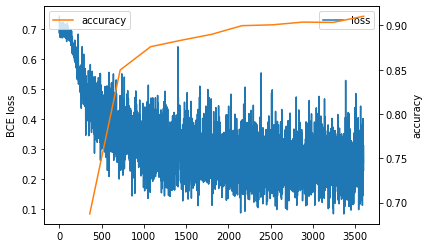

In [52]:
xs = np.arange(len(train_loader), len(loss_history) + len(train_loader), len(train_loader))

plt.plot(loss_history, label="loss")
plt.ylabel("BCE loss")
plt.legend()
plt.twinx()
plt.plot(xs, train_acc_history, label="accuracy", c="C1")
plt.ylabel("accuracy")
plt.legend()
plt.show()

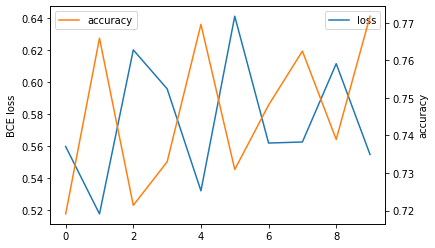

In [53]:
eval_loss_history = [x.cpu() for x in eval_loss_history]
plt.plot(eval_loss_history, label="loss")
plt.legend()
plt.ylabel("BCE loss")
plt.twinx()
plt.plot(eval_acc_history, c="C1", label="accuracy")
plt.ylabel("accuracy")
plt.legend()
plt.show()